In [1]:
from scipy.stats import skewnorm
import seaborn as sns
import numpy as np
import statistics
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import brentq
plt.rc('axes', labelsize=12)  

### Initialize 3000 data points from right skewed normal distribution, with the minimum value of 0

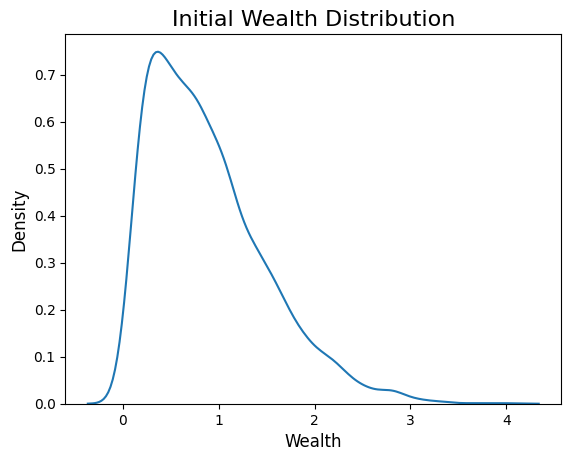

In [2]:
seed_value = 12310628
rng = np.random.default_rng(seed_value)

# Generate data
data10 = skewnorm.rvs(20, size=3000, random_state=rng)
adjusted_data10 = data10 - min(data10)

# Plot using kdeplot for smooth density estimation
sns.kdeplot(adjusted_data10)
plt.xlabel('Wealth')
plt.title('Initial Wealth Distribution', fontsize=16)
plt.show()

### Penalty funtion: $G(x_Tp_T)=m(x_Tp_T)^2$, $\partial_{x_T}G=2mp_T^2x_T$ 

### $ x_T^{(i)}$ solves  $ x_T^{(i)}+\frac{k\partial_xG(x_T^{(i)}\cdot p_T)}{2} \frac{T}{aggcon}=x_0^{(i)},$ for all $i$
### $T=1,Lbound=0, Ubound=4.2,stepsize=0.01$

In [3]:
max(adjusted_data10)

3.9727488013188874

In [4]:
min(adjusted_data10)

0.0

### Random terminal prices according to geometric brownian motion: $p_T=p_0\cdot\exp((\mu-\frac{\sigma^2}{2})T+\sigma W_T),p_0=1$ 

In [5]:
np.random.seed(12310628)

In [6]:
p_0=1
T=1
mu=0.03
sigma=0.2
k=5

m=0.05

In [7]:
p_list=[p_0*np.exp((mu-sigma**2/2)*T+sigma*T**(1/2)*np.random.standard_normal()) for i in range(1000)]

### For a deterministic terminal price, calculate a deterministic aggregated control of the population, and collect the distribution of the terminal weath (Algorithm 1)

In [8]:
def deterministic_aggcon(T,p,k,m):
    for aggcon in np.arange(0.01,4.2,0.005):
        control_list=[]
        x_T_list=[]
        for x0 in adjusted_data10:
            x_T=x0/(1+k*m*p**2*T/aggcon)
            control=k*m*p**2*x_T/aggcon
            control_list.append(control)
            x_T_list.append(x_T)
        aggcon_new=statistics.mean(control_list)
        if abs(aggcon_new-aggcon)<=0.005:
            return aggcon_new,x_T_list
        
    

In [9]:
a,terminallist=deterministic_aggcon(T,p_list[400],k,m)

In [10]:
print(a)

0.31431431710398877


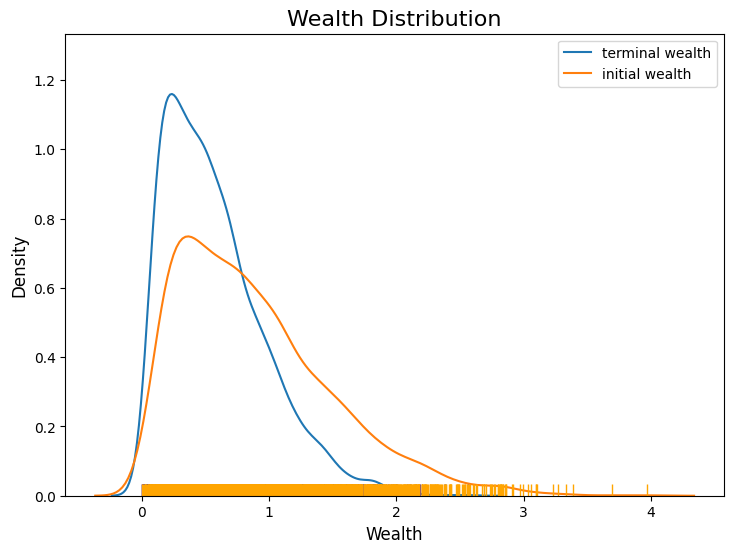

In [11]:
#single simulation for one determinitic price path.
fig = plt.figure(figsize=(8.5, 6))
sns.kdeplot(terminallist, label='terminal wealth')
sns.kdeplot(adjusted_data10, label='initial wealth')
sns.rugplot(terminallist, color='blue')
sns.rugplot(adjusted_data10, color='orange')
plt.title('Wealth Distribution', fontsize=16)
plt.xlabel('Wealth')
plt.legend()
plt.show()

### Monte-Carlo simulation on the price paths

In [12]:
terminal_wealth_collection=[]
AC_collection=[]
for p in p_list:
    AC,terminalwealth=deterministic_aggcon(T,p,k,m)
    if AC is None:
        continue
    elif AC is not None:
        terminal_wealth_collection=terminal_wealth_collection+terminalwealth
        AC_collection=AC_collection+[AC]
mean_AC=statistics.mean(AC_collection)


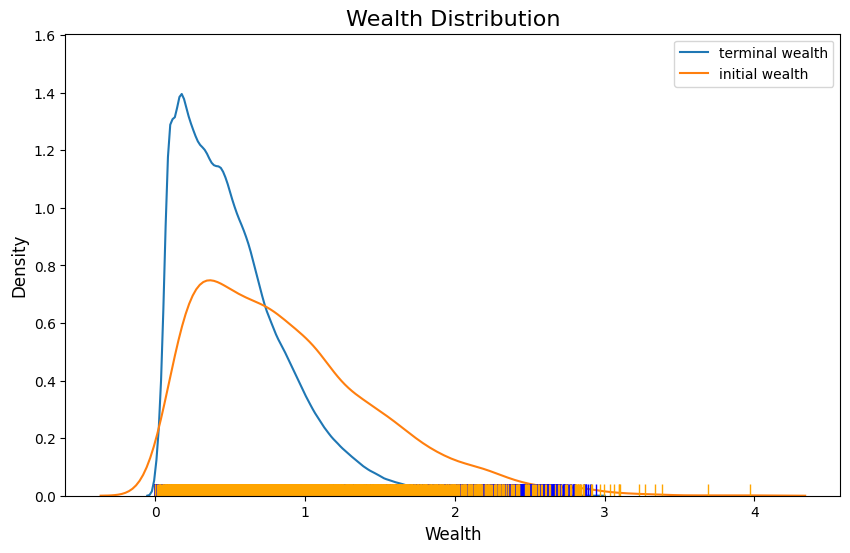

In [13]:
# Aggregated distribution of 1000 simulations
fig = plt.figure(figsize=(10, 6))

sns.kdeplot(terminal_wealth_collection, label='terminal wealth')
sns.kdeplot(adjusted_data10, label='initial wealth')

sns.rugplot(terminal_wealth_collection, color='blue')
sns.rugplot(adjusted_data10, color='orange')

plt.legend()
plt.xlabel('Wealth')
plt.title('Wealth Distribution', fontsize=16)
plt.show()

In [14]:
mean_AC

0.36805072288914903

In [15]:
np.mean(adjusted_data10)

0.8867105723495594

In [16]:
np.mean(terminal_wealth_collection)

0.5186598494604101

In [17]:
len(terminal_wealth_collection)

3000000

In [18]:
sigma_list=np.arange(0.1,0.6,0.05)
mu_list=np.arange(0.01,0.1,0.01)

In [19]:
np.random.seed(12310628)
snrv_set=[np.random.standard_normal() for i in range(500)]

In [20]:
def terminal_price_set(mu,sigma):
    return [p_0*np.exp((mu-sigma**2/2)*T+sigma*T**(1/2)*snrv) for snrv in snrv_set]

In [21]:
AC_sigmaset=[]
for sigma in sigma_list:
    terminal_wealth_collection=[]
    AC_collection=[]
    for p in terminal_price_set(0.03,sigma):
        AC,terminalwealth=deterministic_aggcon(T,p,k,m)
        if AC is None:
            continue
        elif AC is not None:
            terminal_wealth_collection=terminal_wealth_collection+terminalwealth
            AC_collection=AC_collection+[AC]
    AC_sigmaset.append(statistics.mean(AC_collection))

In [22]:
AC_sigmaset=[0.3709388713100204,
 0.3706734269420363,
 0.369921197352863,
 0.3687896060726467,
 0.3670378876535695,
 0.3650266161833561,
 0.36254167917636376,
 0.3597344199507109,
 0.3564628707345484,
 0.35288029294918827]

In [23]:
AC_muset=[]
for mu in mu_list:
    terminal_wealth_collection=[]
    AC_collection=[]
    for p in terminal_price_set(mu,0.2):
        AC,terminalwealth=deterministic_aggcon(T,p,k,m)
        if AC is None:
            continue
        elif AC is not None:
            terminal_wealth_collection=terminal_wealth_collection+terminalwealth
            AC_collection=AC_collection+[AC]
    AC_muset.append(statistics.mean(AC_collection))

In [24]:
AC_muset=[0.364539342647875,
 0.3672277465660629,
 0.369921197352863,
 0.3725599191067315,
 0.3753599484368191,
 0.3779966556738807,
 0.3807160507004899,
 0.3834265110301436,
 0.3862457559630725]

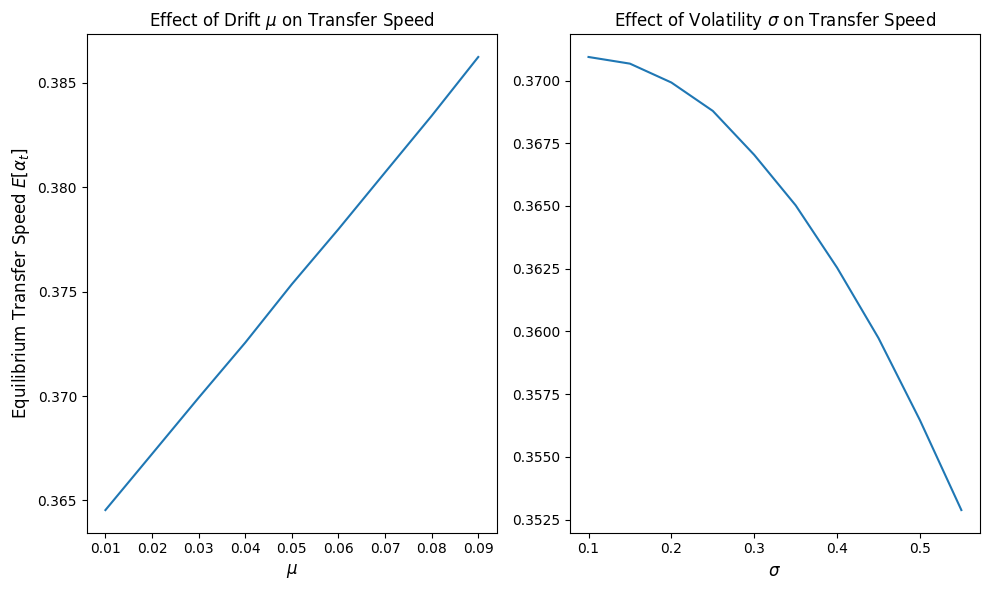

In [25]:
#Equilibrium transfer speed according to different asset drift $\mu$ and volatility $\sigma$.
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].plot(mu_list, AC_muset)
axs[0].set_ylabel('Equilibrium Transfer Speed $E[\\alpha_t]$')
axs[0].set_xlabel('$\\mu$')
axs[0].set_title('Effect of Drift $\\mu$ on Transfer Speed')  


axs[1].plot(sigma_list, AC_sigmaset)
axs[1].set_xlabel('$\\sigma$')
axs[1].set_title('Effect of Volatility $\\sigma$ on Transfer Speed') 


plt.tight_layout()
plt.show()

In [26]:
len(terminal_wealth_collection)

1500000

In [27]:
mean_AC

0.36805072288914903

In [28]:
np.mean(adjusted_data10)

0.8867105723495594

In [29]:
np.mean(terminal_wealth_collection)

0.5020303880644083

### Exponential penalty: $G(xp)=m(e^{xp}-xp)$, $\partial_x G(xp)=mp(e^x-1)$

In [30]:
def deterministic_aggcon_exp(T,p,k,m):
    for aggcon in np.arange(0.01,4.2,0.005):
        control_list=[]
        x_T_list=[]
        for x0 in adjusted_data10:
            f = lambda x: x+k*m*p*T/2/aggcon*(np.exp(x*p)-1)-x0
            solution=brentq(f, 0, x0)
            x_T=solution
            control=k*m*p*(np.exp(x_T*p)-1)/aggcon/2
            control_list.append(control)
            x_T_list.append(x_T)
        aggcon_new=statistics.mean(control_list)
        if abs(aggcon_new-aggcon)<=0.005:
            return aggcon_new,x_T_list

In [31]:
AC_exp, wealth_exp=deterministic_aggcon_exp(T,p_list[55],k,m)

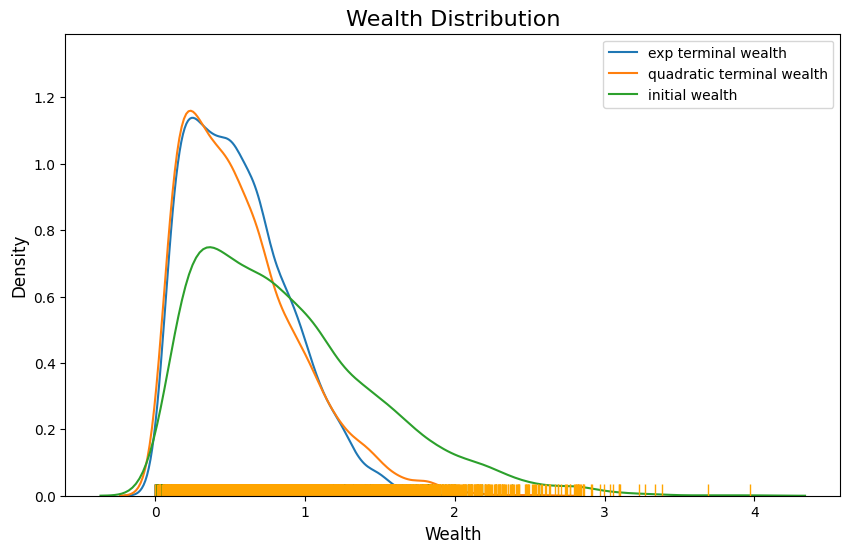

In [32]:
# Single simulation for one deterministic price path
fig = plt.figure(figsize=(10, 6))

sns.kdeplot(wealth_exp, label='exp terminal wealth')
sns.kdeplot(terminallist, label='quadratic terminal wealth')
sns.kdeplot(adjusted_data10, label='initial wealth')

sns.rugplot(wealth_exp, color='blue')
sns.rugplot(terminallist, color='green')
sns.rugplot(adjusted_data10, color='orange')

plt.title('Wealth Distribution', fontsize=16)
plt.xlabel('Wealth')
plt.legend()
plt.show()


In [33]:
f=lambda x: x+1-10
a=fsolve(f,[-100,100])

In [34]:
min(terminallist)

0.0

In [35]:
a[0]

9.0

### MC on quadratic penalty

In [36]:
qua_terminal_wealth_collection=[]
qua_AC_collection=[]
for p in p_list:
    AC,terminalwealth=deterministic_aggcon(T,p,k,m)
    if AC is None:
        continue
    elif AC is not None:
        qua_terminal_wealth_collection=qua_terminal_wealth_collection+terminalwealth
        qua_AC_collection=qua_AC_collection+[AC]

### MC on exp penalty

In [37]:
exp_terminal_wealth_collection=[]
exp_AC_collection=[]
for p in p_list:
    AC,terminalwealth=deterministic_aggcon_exp(T,p,k,m)
    if AC is None:
        continue
    elif AC is not None:
        exp_terminal_wealth_collection=exp_terminal_wealth_collection+terminalwealth
        exp_AC_collection=exp_AC_collection+[AC]

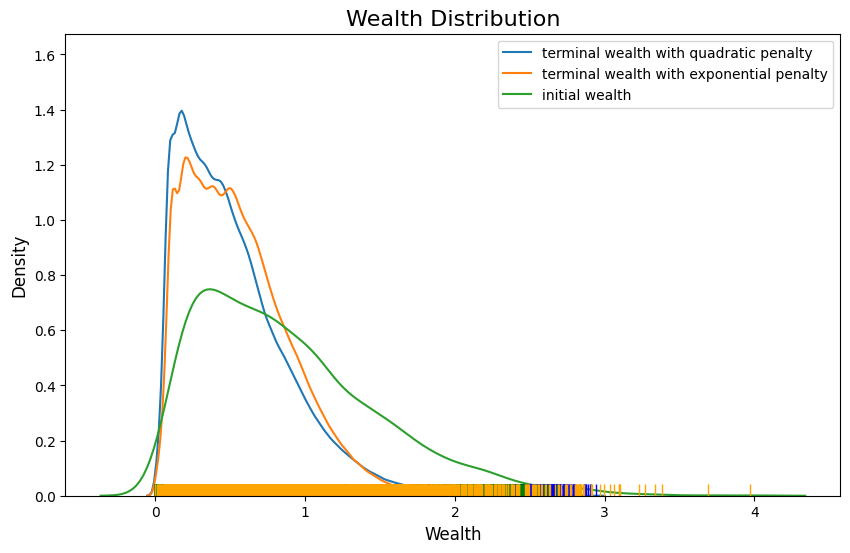

In [38]:
# Aggregated distribution of 1000 simulations
fig = plt.figure(figsize=(10, 6))

sns.kdeplot(qua_terminal_wealth_collection, label='terminal wealth with quadratic penalty')
sns.kdeplot(exp_terminal_wealth_collection, label='terminal wealth with exponential penalty')
sns.kdeplot(adjusted_data10, label='initial wealth')

sns.rugplot(qua_terminal_wealth_collection, color='blue')
sns.rugplot(exp_terminal_wealth_collection, color='green')
sns.rugplot(adjusted_data10, color='orange')

plt.title('Wealth Distribution', fontsize=16)
plt.xlabel('Wealth')
plt.legend()
plt.show()


In [39]:
np.mean(exp_AC_collection)

0.33409577598440754

In [40]:
np.mean(qua_AC_collection)

0.36805072288914903

In [41]:
np.mean(adjusted_data10)

0.8867105723495594

In [42]:
np.mean(qua_terminal_wealth_collection)

0.5186598494604101

In [43]:
np.mean(exp_terminal_wealth_collection)

0.5526147963651311

### Gini coefficient to generate wealth distribution: $w(x)=kx^{k-1}$


In [44]:
gini=0.5

In [45]:
a=(1+0.309)/(1-0.309)

In [46]:
b=(1+0.306)/(1-0.306)

In [47]:
0.5**a

0.26899364494766265

In [48]:
0.5**b

0.2713366097352602

In [49]:
gini_set=[0.306,0.309,0.308,0.307]

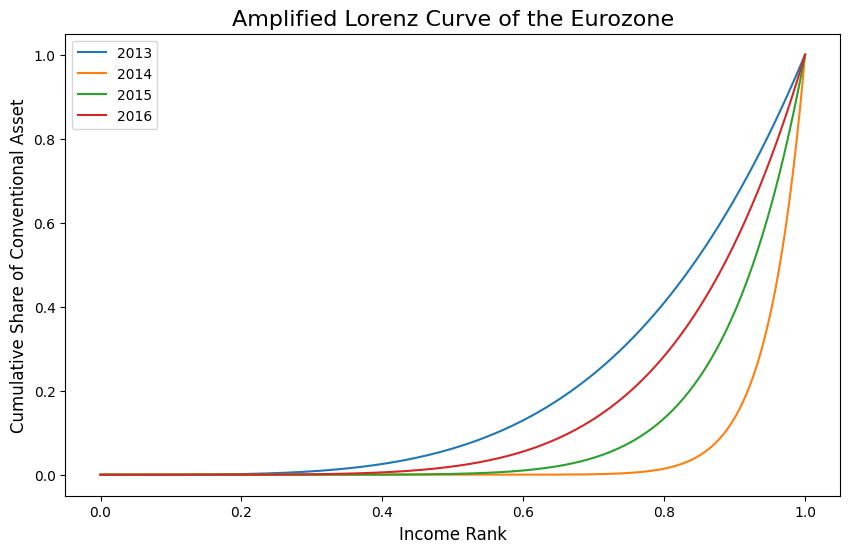

In [50]:
def f(x,gini):
    k=(1+gini)/(1-gini)
    return x**k

# Create an array of x values
x = np.linspace(0, 1, 400)  # 400 evenly spaced points between -10 and 10

# Compute y values by applying the function to x
y1 = f(x,0.3*2)
y2 = f(x,0.45*2)
y3 = f(x,0.4*2)
y4 = f(x,0.35*2)

# Plot the function
plt.figure(figsize=(10,6))
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.plot(x, y4)

# Add labels and title
plt.xlabel('Income Rank')
plt.ylabel('Cumulative Share of Conventional Asset')
plt.title('Amplified Lorenz Curve of the Eurozone', fontsize=16)
plt.legend(labels=['2013','2014','2015','2016'])

# Display the plot
plt.show()

In [51]:
pop_set=np.arange(0.001,1,0.001)

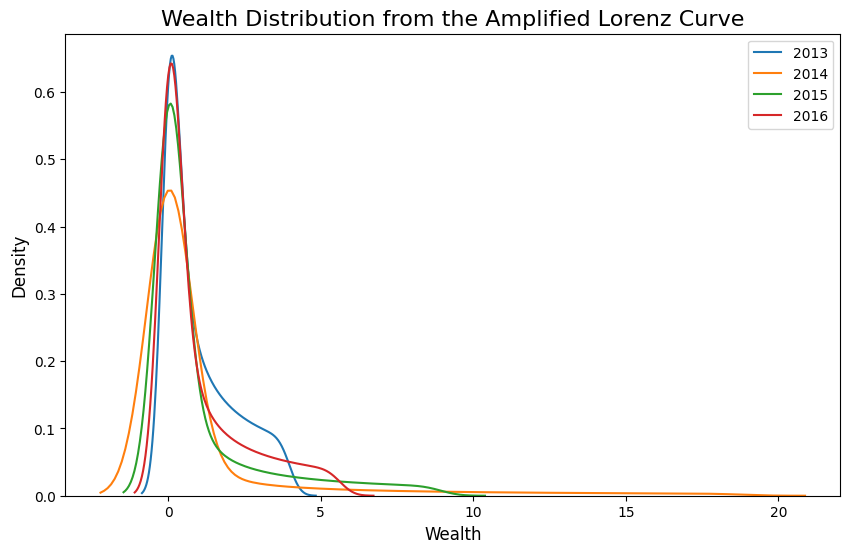

In [52]:
# Define the Lorenz parameterization function
def para_lorenz(gini):
    return (1 + gini) / (1 - gini)

# Generate data sets based on the Lorenz parameterization
diset_2013 = [para_lorenz(0.6) * x**(para_lorenz(0.6) - 1) for x in pop_set]
diset_2014 = [para_lorenz(0.9) * x**(para_lorenz(0.9) - 1) for x in pop_set]
diset_2015 = [para_lorenz(0.8) * x**(para_lorenz(0.8) - 1) for x in pop_set]
diset_2016 = [para_lorenz(0.7) * x**(para_lorenz(0.7) - 1) for x in pop_set]

# Create the plot
plt.figure(figsize=(10, 6))

sns.kdeplot(diset_2013, label='2013')
sns.kdeplot(diset_2014, label='2014')
sns.kdeplot(diset_2015, label='2015')
sns.kdeplot(diset_2016, label='2016')

plt.xlabel('Wealth')
plt.legend()
plt.title('Wealth Distribution from the Amplified Lorenz Curve', fontsize=16)
plt.show()


In [53]:
max(diset_2013),max(diset_2014),max(diset_2015),max(diset_2016)

(3.988011996, 18.660891553977564, 8.928251496629498, 5.6402706606270065)

In [54]:
m=0.01

In [55]:
def deterministic_aggcon_euro(T,p,k,m,data):
    for aggcon in np.arange(0.01,max(data),0.005):
        control_list=[]
        x_T_list=[]
        for x0 in data:
            x_T=x0/(1+k*m*p**2*T/aggcon)
            control=k*m*p**2*x_T/aggcon
            control_list.append(control)
            x_T_list.append(x_T)
        aggcon_new=statistics.mean(control_list)
        if abs(aggcon_new-aggcon)<=0.005:
            return aggcon_new,x_T_list
        
def deterministic_aggcon_exp_euro(T,p,k,m,data):
    for aggcon in np.arange(0.01,max(data),0.005):
        control_list=[]
        x_T_list=[]
        for x0 in data:
            f = lambda x: x+k*m*p*T/2/aggcon*(np.exp(x*p)-1)-x0
            solution=brentq(f, 0, x0)
            x_T=solution
            control=k*m*p*(np.exp(x_T*p)-1)/aggcon/2
            control_list.append(control)
            x_T_list.append(x_T)
        aggcon_new=statistics.mean(control_list)
        if abs(aggcon_new-aggcon)<=0.005:
            return aggcon_new,x_T_list

In [56]:
T=1
k_2013=1.8
k_2014=20
k_2015=26
k_2016=54
m=0.005
mu_2013=0.005
mu_2014=0.0015
mu_2015=0.0005
mu_2016=0
p_0=1

In [57]:
terminal_wealth_collection=[]
AC_collection=[]
for p in terminal_price_set(mu_2013,0.2):
    AC,terminalwealth=deterministic_aggcon_euro(T,p,k_2013,m,diset_2013)
    if AC is None:
        continue
    elif AC is not None:
        terminal_wealth_collection=terminal_wealth_collection+terminalwealth
        AC_collection=AC_collection+[AC]
mean_AC_2013=statistics.mean(AC_collection)

In [58]:
terminal_wealth_collection=[]
AC_collection=[]
for p in terminal_price_set(mu_2014,0.2):
    AC,terminalwealth=deterministic_aggcon_euro(T,p,k_2014,m,diset_2014)
    if AC is None:
        continue
    elif AC is not None:
        terminal_wealth_collection=terminal_wealth_collection+terminalwealth
        AC_collection=AC_collection+[AC]
mean_AC_2014=statistics.mean(AC_collection)

In [59]:
terminal_wealth_collection=[]
AC_collection=[]
for p in terminal_price_set(mu_2015,0.2):
    AC,terminalwealth=deterministic_aggcon_euro(T,p,k_2015,m,diset_2015)
    if AC is None:
        continue
    elif AC is not None:
        terminal_wealth_collection=terminal_wealth_collection+terminalwealth
        AC_collection=AC_collection+[AC]
mean_AC_2015=statistics.mean(AC_collection)

In [60]:
terminal_wealth_collection=[]
AC_collection=[]
for p in terminal_price_set(mu_2016,0.2):
    AC,terminalwealth=deterministic_aggcon_euro(T,p,k_2016,10*m,diset_2016)
    if AC is None:
        continue
    elif AC is not None:
        terminal_wealth_collection=terminal_wealth_collection+terminalwealth
        AC_collection=AC_collection+[AC]
mean_AC_2016=statistics.mean(AC_collection)

In [61]:
mean_AC_euro=[mean_AC_2013,mean_AC_2014,mean_AC_2015,mean_AC_2016]

In [62]:
mean_greenium=[mean_AC_2013/k_2013,mean_AC_2014/k_2014,mean_AC_2015/k_2015,mean_AC_2016/k_2016]

In [63]:
mean_log_greenium=[np.log(1+mean_AC_2013/k_2013),np.log(1+mean_AC_2014/k_2014),np.log(1+mean_AC_2015/k_2015),np.log(1+mean_AC_2016/k_2016)]

In [64]:
import datetime

In [65]:
yearset=['2013','2014','2015','2016']

In [66]:
market_greenium=[99,48,1,69]

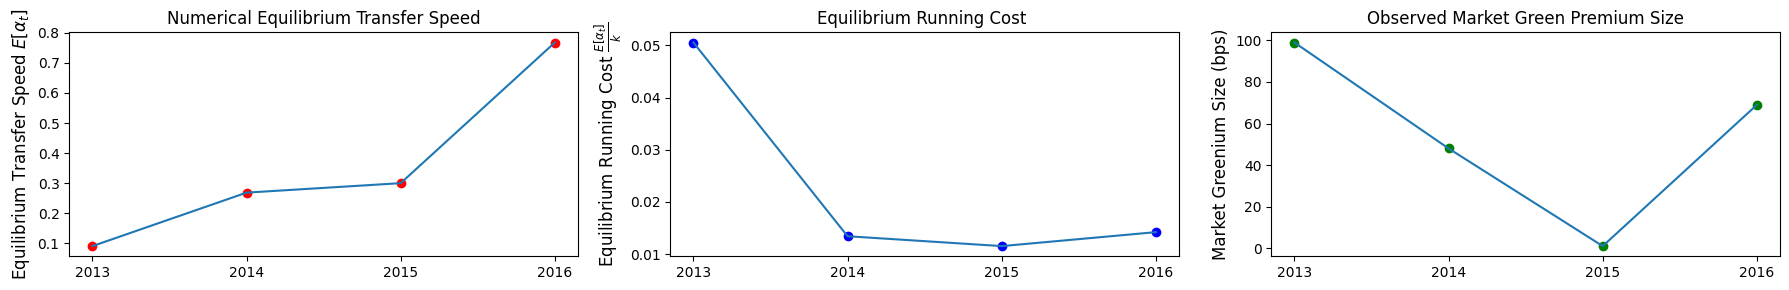

In [67]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3))

axs[0].plot(yearset, mean_AC_euro, 'or', yearset, mean_AC_euro)
axs[0].set_ylabel('Equilibrium Transfer Speed $E[\\alpha_t]$')
axs[0].set_title('Numerical Equilibrium Transfer Speed')

axs[1].plot(yearset, mean_greenium, 'ob', yearset, mean_greenium)
axs[1].set_ylabel('Equilibrium Running Cost $\\frac{E[\\alpha_t]}{k}$')
axs[1].set_title('Equilibrium Running Cost ')

axs[2].plot(yearset, market_greenium, 'og', yearset, market_greenium)
axs[2].set_ylabel('Market Greenium Size (bps)')
axs[2].set_title('Observed Market Green Premium Size')

plt.tight_layout()
plt.show()

In [68]:
absence_interval=[j/i*10000 for i,j in zip(market_greenium,mean_greenium)]

In [69]:
absence_interval

[5.104223114972235, 2.798767763488738, 115.44552910482547, 2.060238124147754]

Text(0.5, 1.0, 'The Green Market Arbitrage Frequency Index')

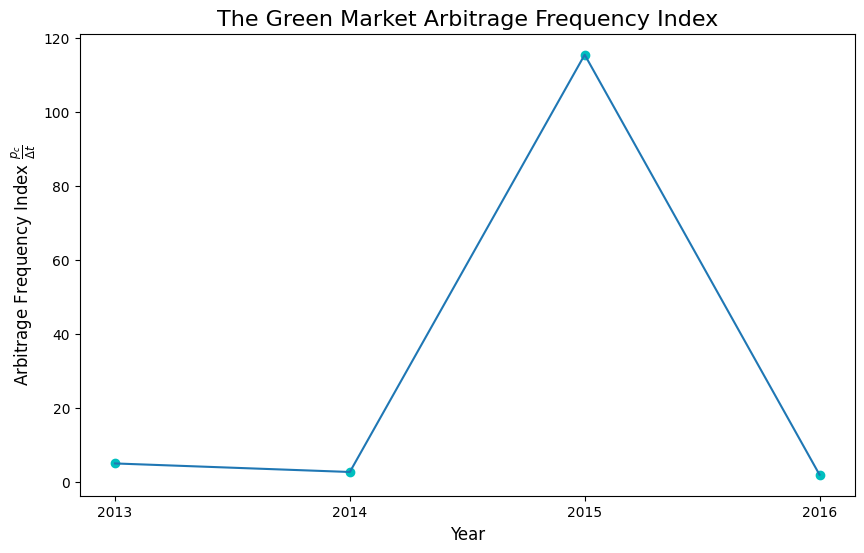

In [70]:
plt.figure(figsize=(10,6))
plt.plot(yearset, absence_interval,'oc',yearset, absence_interval)
plt.ylabel('Arbitrage Frequency Index $\\frac{p_c}{\\Delta t}$')
plt.xlabel('Year')
plt.title('The Green Market Arbitrage Frequency Index', fontsize=16)

In [71]:
0.6*(0.1)**(-0.4)

1.507131858905748

In [72]:
0.6*(0.15)**(-0.4)

1.2814885990147225

In [73]:
np.log(2)

0.6931471805599453